In [ ]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM


In [ ]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
# Downloading price data

tickers = ["TLT", "GLD", "SPY", "^VIX"]

close_prices = pd.DataFrame()

for ticker in tickers:
        print(f"Downloading {ticker}...")
        try:

            temp_data = yf.download(ticker, start="2005-01-01", progress=False, auto_adjust=True)
            close_prices[ticker] = temp_data['Close']
            print(f"  Success: {len(temp_data)} records")
        except Exception as e:
            print(f"  Error downloading {ticker}: {e}")

print(f"\nFinal price data shape: {close_prices.shape}")
print("First few rows:")
display(close_prices.head())

# Checking for missing values
print("\nMissing values:")
print(close_prices.isnull().sum())

  Success: 5247 records
  Success: 5247 records
  Success: 5247 records
  Success: 5247 records

Final price data shape: (5247, 4)
First few rows:


,TLT,GLD,SPY,^VIX
Date,,,,
2005-01-03,45.395805,43.020000,81.847137,14.08
2005-01-04,44.920090,42.740002,80.847023,13.98
2005-01-05,45.160519,42.669998,80.289078,14.09
2005-01-06,45.191189,42.150002,80.697304,13.58
2005-01-07,45.293510,41.840000,80.581635,13.49



Missing values:
TLT     0
GLD     0
SPY     0
^VIX    0
dtype: int64


In [ ]:
# Computing daily log-returns for ETFs and daily change for VIX

returns = pd.DataFrame()

# Calculating log returns for ETFs
returns["TLT"] = np.log(close_prices["TLT"] / close_prices["TLT"].shift(1))
returns["GLD"] = np.log(close_prices["GLD"] / close_prices["GLD"].shift(1))
returns["SPY"] = np.log(close_prices["SPY"] / close_prices["SPY"].shift(1))


returns["dVIX"] = close_prices["^VIX"].diff()

# missing values dropped
returns = returns.dropna()

print(f"\nReturns data shape: {returns.shape}")
print("First few rows of returns:")
display(returns.head())


Returns data shape: (5246, 4)
First few rows of returns:


,TLT,GLD,SPY,dVIX
Date,,,,
2005-01-04,-0.010535,-0.006530,-0.012295,-0.100000
2005-01-05,0.005338,-0.001639,-0.006925,0.110001
2005-01-06,0.000679,-0.012261,0.005072,-0.510000
2005-01-07,0.002262,-0.007382,-0.001434,-0.090000
2005-01-10,0.001580,0.002626,0.004717,-0.260000


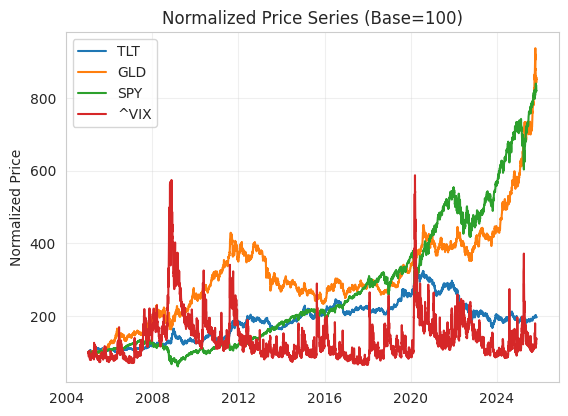

In [ ]:
# Plot of Normalized Price series (normalized to 100)
normalized_prices = (close_prices / close_prices.iloc[0]) * 100

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
for column in normalized_prices.columns:
    plt.plot(normalized_prices.index, normalized_prices[column], label=column, linewidth=1.5)
plt.title('Normalized Price Series (Base=100)')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True, alpha=0.3)


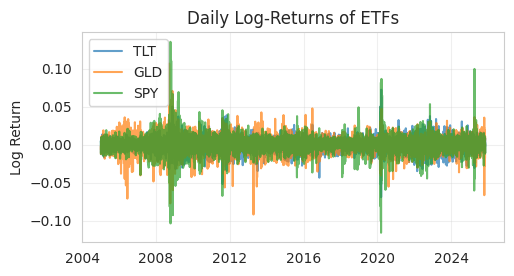

In [ ]:
# Plot 2: ETF returns
plt.subplot(2, 2, 2)
plt.plot(returns.index, returns["TLT"], label="TLT", alpha=0.7)
plt.plot(returns.index, returns["GLD"], label="GLD", alpha=0.7)
plt.plot(returns.index, returns["SPY"], label="SPY", alpha=0.7)
plt.title("Daily Log-Returns of ETFs")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True, alpha=0.3)


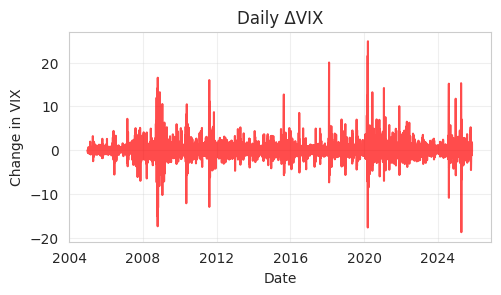

In [ ]:
# Plot of ΔVIX
plt.subplot(2, 2, 3)
plt.plot(returns.index, returns["dVIX"], color='red', alpha=0.7)
plt.title("Daily ΔVIX")
plt.xlabel("Date")
plt.ylabel("Change in VIX")
plt.grid(True, alpha=0.3)

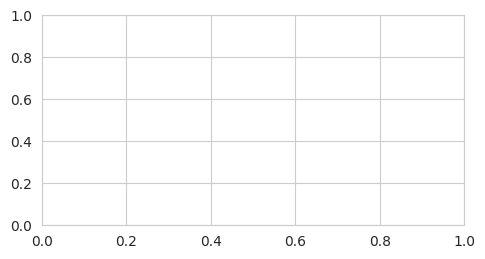

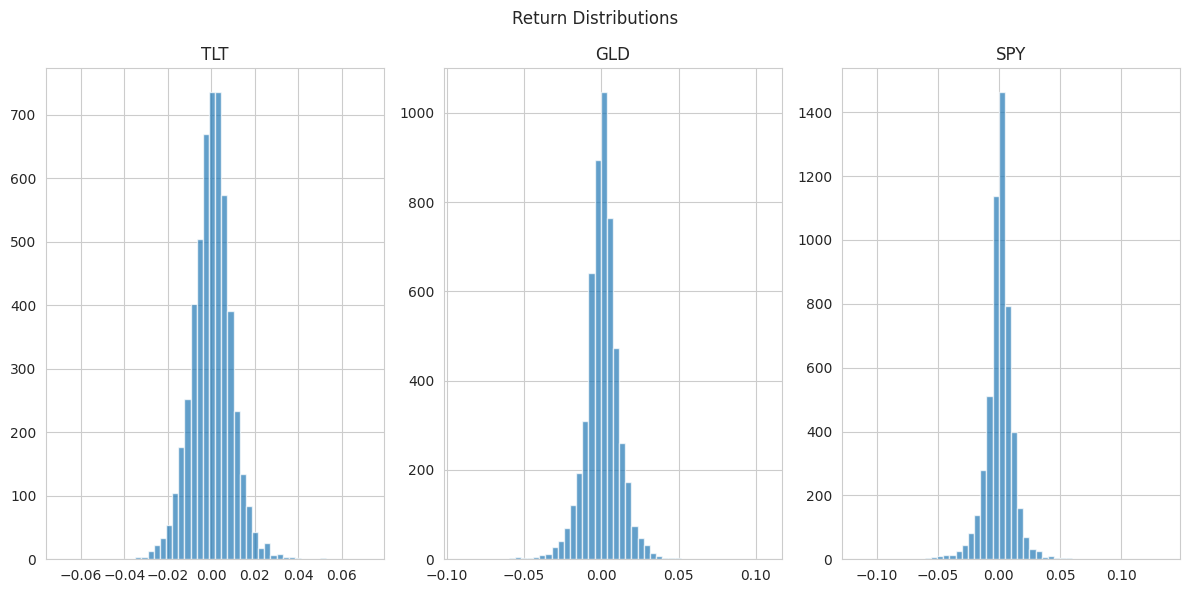

In [ ]:
# Plot of Return distributions
plt.subplot(2, 2, 4)
returns[["TLT", "GLD", "SPY"]].hist(bins=50, alpha=0.7, layout=(1, 3))
plt.suptitle("Return Distributions")
plt.tight_layout()

plt.show()

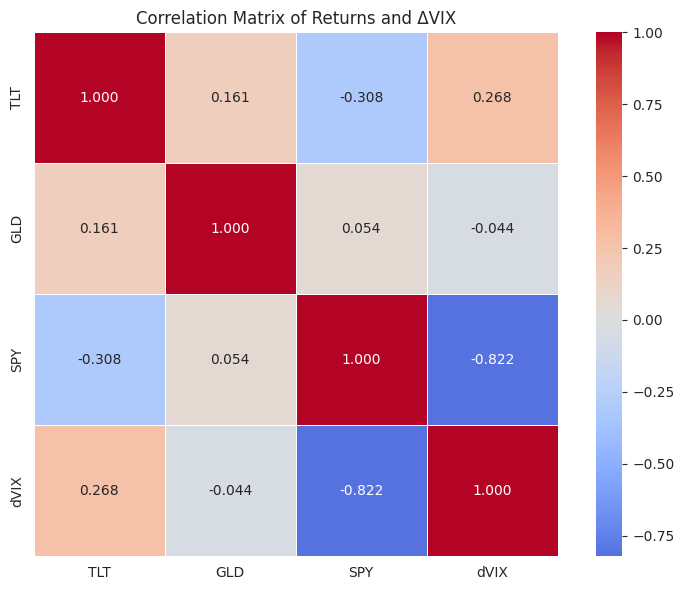

Correlation Matrix:
           TLT       GLD       SPY      dVIX
TLT   1.000000  0.160833 -0.308254  0.267848
GLD   0.160833  1.000000  0.054301 -0.044080
SPY  -0.308254  0.054301  1.000000 -0.821685
dVIX  0.267848 -0.044080 -0.821685  1.000000


In [ ]:
#  Correlation analysis

correlation_matrix = returns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.3f')
plt.title("Correlation Matrix of Returns and ΔVIX")
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(correlation_matrix)

In [ ]:
#  Statistical analysis

print("\nDetailed Statistics:")
stats_summary = pd.DataFrame({
    'Mean_Daily_Return': returns.mean(),
    'Std_Daily_Return': returns.std(),
    'Annualized_Volatility': returns[['TLT', 'GLD', 'SPY']].std() * np.sqrt(252),
    'Annualized_Sharpe': returns[['TLT', 'GLD', 'SPY']].mean() / returns[['TLT', 'GLD', 'SPY']].std() * np.sqrt(252),
    'Min_Daily_Return': returns.min(),
    'Max_Daily_Return': returns.max(),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis()
})

print(stats_summary.round(4))



Detailed Statistics:
      Mean_Daily_Return  Std_Daily_Return  Annualized_Volatility  \
GLD              0.0004            0.0111                 0.1768   
SPY              0.0004            0.0120                 0.1911   
TLT              0.0001            0.0093                 0.1471   
dVIX             0.0010            1.9172                    NaN   

      Annualized_Sharpe  Min_Daily_Return  Max_Daily_Return  Skewness  \
GLD              0.5835           -0.0919            0.1070   -0.3283   
SPY              0.5289           -0.1159            0.1356   -0.3044   
TLT              0.2219           -0.0690            0.0725    0.0038   
dVIX                NaN          -18.7100           24.8600    1.4457   

      Kurtosis  
GLD     5.8974  
SPY    14.6799  
TLT     3.3894  
dVIX   25.9493  


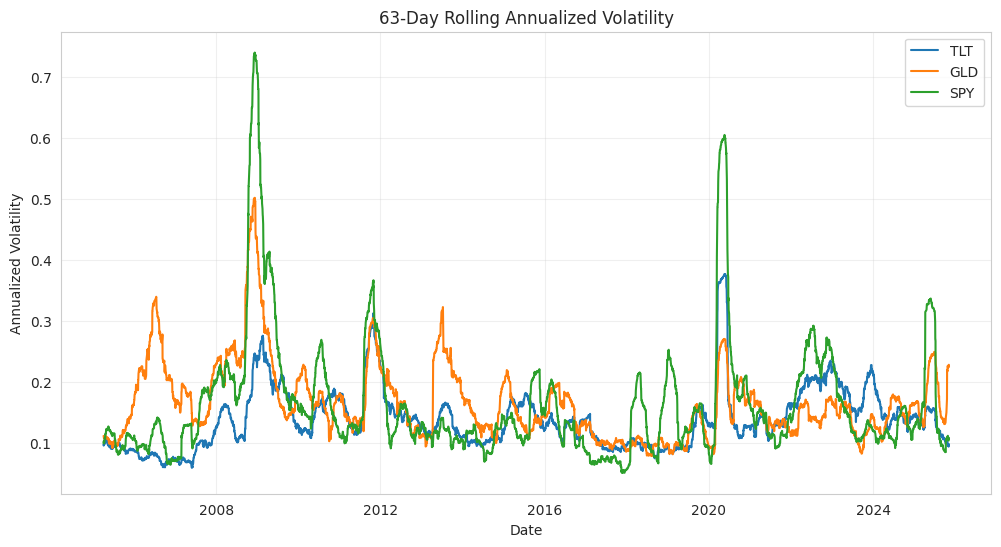

In [ ]:
#  Rolling volatility analysis

rolling_volatility = returns[['TLT', 'GLD', 'SPY']].rolling(window=63).std() * np.sqrt(252)

plt.figure(figsize=(12, 6))
plt.plot(rolling_volatility.index, rolling_volatility)
plt.title("63-Day Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend(['TLT', 'GLD', 'SPY'])
plt.grid(True, alpha=0.3)
plt.show()



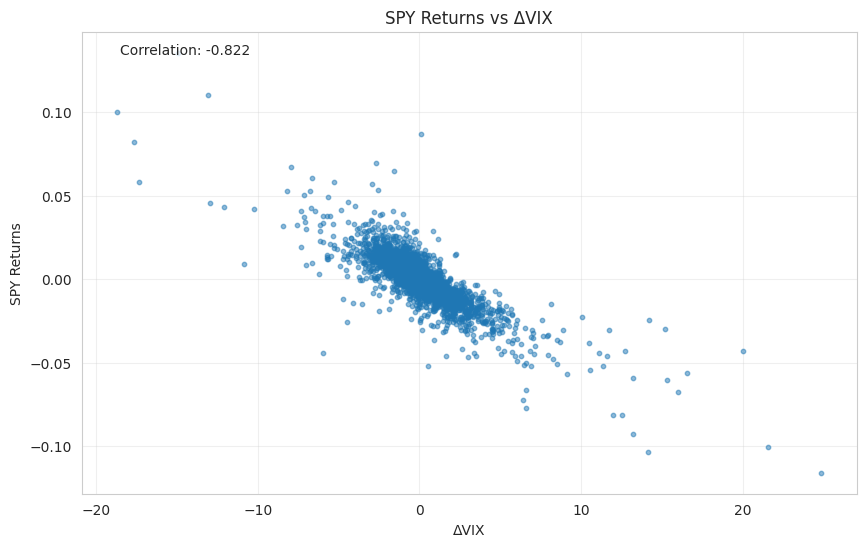

In [ ]:

# VIX vs SPY returns scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(returns["dVIX"], returns["SPY"], alpha=0.5, s=10)
plt.xlabel("ΔVIX")
plt.ylabel("SPY Returns")
plt.title("SPY Returns vs ΔVIX")
plt.grid(True, alpha=0.3)

corr = returns["dVIX"].corr(returns["SPY"])
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.show()

## **Step 2**

In [ ]:
# STEP 2: HIDDEN MARKOV MODEL FOR ΔVIX


dVIX = returns["dVIX"].dropna().values.reshape(-1,1)


#  Fitting 2-state HMM

model_2 = GaussianHMM(n_components=2, covariance_type='full', n_iter=200)
model_2.fit(dVIX)

states_2 = model_2.predict(dVIX)

print("\n 2-State HMM Parameters ")
print("Means:", model_2.means_.flatten())
print("Variances:", [np.diag(cov) for cov in model_2.covars_])
print("Transition Matrix:\n", model_2.transmat_)


--- 2-State HMM Parameters ---
Means: [ 0.22528967 -0.07448549]
Variances: [array([12.52761492]), array([0.67524709])]
Transition Matrix:
 [[0.88205505 0.11794495]
 [0.03968083 0.96031917]]


In [ ]:

#  Fit 3-state HMM

model_3 = GaussianHMM(n_components=3, covariance_type='full', n_iter=200)
model_3.fit(dVIX)

states_3 = model_3.predict(dVIX)

print("\n--- 3-State HMM Parameters ---")
print("Means:", model_3.means_.flatten())
print("Variances:", [np.diag(cov) for cov in model_3.covars_])
print("Transition Matrix:\n", model_3.transmat_)



--- 3-State HMM Parameters ---
Means: [-0.0620278  -0.01347739  0.62548442]
Variances: [array([0.37757506]), array([2.98231782]), array([35.50867948])]
Transition Matrix:
 [[9.38348545e-01 6.10991618e-02 5.52293693e-04]
 [7.34957017e-02 9.09075640e-01 1.74286579e-02]
 [1.39521041e-14 1.25728700e-01 8.74271300e-01]]


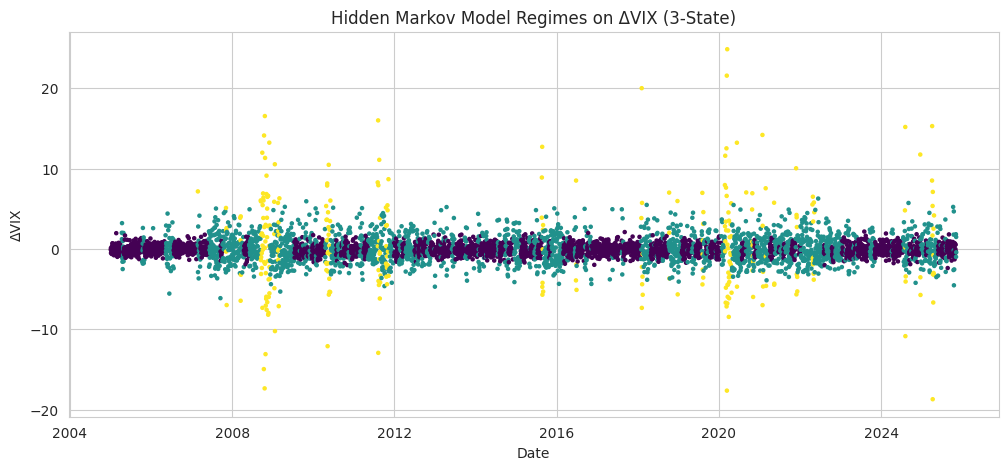

In [ ]:

# Plotting 3-state HMM states on ΔVIX

plt.figure(figsize=(12,5))
plt.scatter(returns.index, returns["dVIX"], c=states_3, cmap="viridis", s=5)
plt.title("Hidden Markov Model Regimes on ΔVIX (3-State)")
plt.xlabel("Date")
plt.ylabel("ΔVIX")
plt.show()

Step 3

In [ ]:
# Log-likelihoods
ll_2 = model_2.score(dVIX)
ll_3 = model_3.score(dVIX)

# Parameter count for Gaussian HMM:
def hmm_params(n_states):
    k = n_states

    return k + k + k*(k-1) + (k-1)

k2 = hmm_params(2)
k3 = hmm_params(3)

# AIC and BIC
AIC_2 = 2*k2 - 2*ll_2
AIC_3 = 2*k3 - 2*ll_3

BIC_2 = k2*np.log(len(dVIX)) - 2*ll_2
BIC_3 = k3*np.log(len(dVIX)) - 2*ll_3

comparison = pd.DataFrame({
    "Model":["2-State HMM","3-State HMM"],
    "Log-Likelihood":[ll_2, ll_3],
    "AIC":[AIC_2, AIC_3],
    "BIC":[BIC_2, BIC_3]
})

print("Model Comparison:")
display(comparison)

Model Comparison:


,Model,Log-Likelihood,AIC,BIC
0,2-State HMM,-8945.333565,17904.667129,17950.623677
1,3-State HMM,-8607.098368,17242.196736,17334.109832


**Extracting state from model**

In [ ]:
states = states_3               # predicted states from Step 2B
returns["state"] = states       # attach states to return dataframe


Computing average ETF returns in each regime:

In [ ]:
group_stats = returns.groupby("state")[["TLT","GLD","SPY"]].agg(["mean","std"])
print("State-Conditional ETF Return Stats:")
display(group_stats)


State-Conditional ETF Return Stats:


TLT                 GLD                 SPY          
           mean       std      mean       std      mean       std
state                                                            
0     -0.000137  0.007503  0.000450  0.009365  0.001318  0.005556
1      0.000250  0.009660  0.000351  0.011484 -0.000035  0.012160
2      0.001673  0.017325  0.000476  0.020023 -0.004749  0.033809

Bar Chart: Mean Return per State

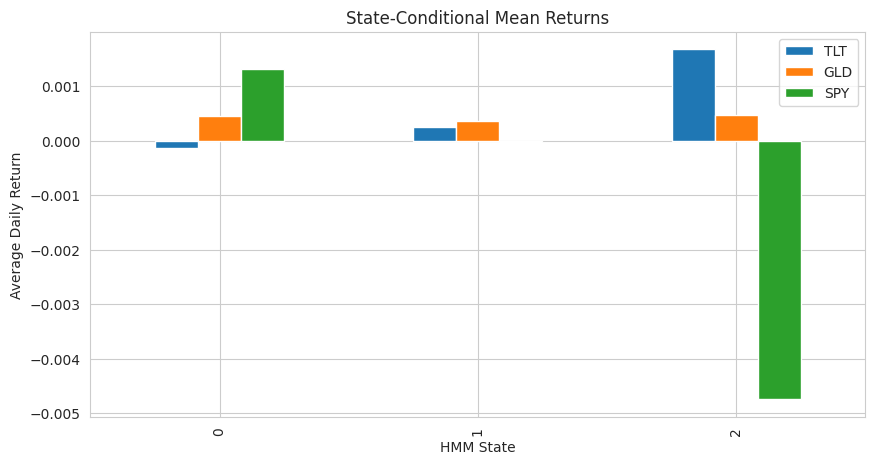

In [ ]:
mean_returns = returns.groupby("state")[["TLT","GLD","SPY"]].mean()

mean_returns.plot(kind="bar", figsize=(10,5))
plt.title("State-Conditional Mean Returns")
plt.ylabel("Average Daily Return")
plt.xlabel("HMM State")
plt.legend(["TLT","GLD","SPY"])
plt.show()


## STEP 4: DESIGN ROTATION STRATEGY, SIGNALS, & STRATEGY RETURNS

State-conditional mean returns (daily):


,TLT,GLD,SPY
state,,,
0,-0.000137,0.000450,0.001318
1,0.000250,0.000351,-0.000035
2,0.001673,0.000476,-0.004749



State → Allocation mapping (Policy A = 100/0, Policy B = 60/40):


,TLT_100p,TLT_60_40p,GLD_100p,GLD_60_40p,SPY_100p,SPY_60_40p
state,,,,,,
0,0.0,0.0,0.0,0.4,1.0,0.6
1,0.0,0.4,1.0,0.6,0.0,0.0
2,1.0,0.6,0.0,0.4,0.0,0.0



Sample allocations (first 8 rows) — Policy A (100/0):


,TLT,GLD,SPY
Date,,,
2005-01-04,0.0,0.0,0.0
2005-01-05,0.0,0.0,1.0
2005-01-06,0.0,0.0,1.0
2005-01-07,0.0,0.0,1.0
2005-01-10,0.0,0.0,1.0
2005-01-11,0.0,0.0,1.0
2005-01-12,0.0,0.0,1.0
2005-01-13,0.0,0.0,1.0



Sample allocations (first 8 rows) — Policy B (60/40):


,TLT,GLD,SPY
Date,,,
2005-01-04,0.0,0.0,0.0
2005-01-05,0.0,0.4,0.6
2005-01-06,0.0,0.4,0.6
2005-01-07,0.0,0.4,0.6
2005-01-10,0.0,0.4,0.6
2005-01-11,0.0,0.4,0.6
2005-01-12,0.0,0.4,0.6
2005-01-13,0.0,0.4,0.6



Sample strategy returns (first 8 rows):


,TLT,GLD,SPY,state,strat_100p,strat_60_40p
Date,,,,,,
2005-01-04,-0.010535,-0.006530,-0.012295,0,0.000000,0.000000
2005-01-05,0.005338,-0.001639,-0.006925,0,-0.006925,-0.004811
2005-01-06,0.000679,-0.012261,0.005072,0,0.005072,-0.001862
2005-01-07,0.002262,-0.007382,-0.001434,0,-0.001434,-0.003813
2005-01-10,0.001580,0.002626,0.004717,0,0.004717,0.003881
2005-01-11,0.005846,0.006179,-0.006915,0,-0.006915,-0.001678
2005-01-12,0.001345,0.009197,0.003295,0,0.003295,0.005656
2005-01-13,0.009583,0.000000,-0.008045,0,-0.008045,-0.004827


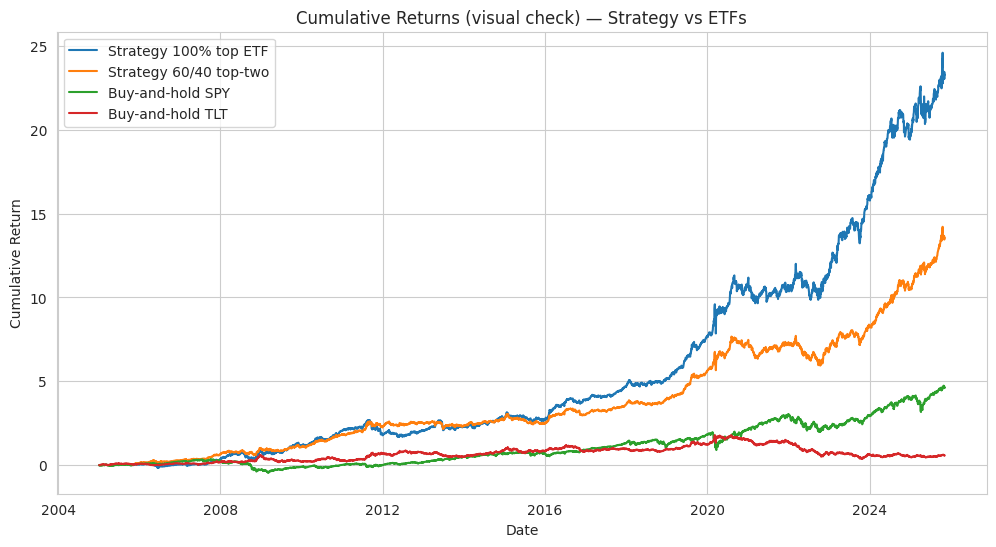

In [ ]:

if "state" not in returns.columns:
    raise ValueError("returns DataFrame must have 'state' column from Step 2/3")

state_mean = returns.groupby("state")[["TLT","GLD","SPY"]].mean()
state_std  = returns.groupby("state")[["TLT","GLD","SPY"]].std()

print("State-conditional mean returns (daily):")
display(state_mean)


etf_list = ["TLT","GLD","SPY"]

def top_n_weights(state_row, policy="100/0"):
    """
    state_row: pandas Series of mean returns for ETFs in the state (index: ETF names)
    policy: "100/0" or "60/40"
    returns: dict mapping ETF -> weight (floats summing to 1)
    """
    sorted_etfs = state_row.sort_values(ascending=False)
    top1 = sorted_etfs.index[0]
    top2 = sorted_etfs.index[1]
    if policy == "100/0":
        weights = {e: 1.0 if e == top1 else 0.0 for e in etf_list}
    elif policy == "60/40":
        weights = {e: 0.0 for e in etf_list}
        weights[top1] = 0.6
        weights[top2] = 0.4
    else:
        raise ValueError("Unknown policy. Use '100/0' or '60/40'.")
    return weights

# Creating a mapping table: state for both policies
alloc_table = []
for s in state_mean.index:
    row = {"state": int(s)}
    mr = state_mean.loc[s]
    w100 = top_n_weights(mr, policy="100/0")
    w6040 = top_n_weights(mr, policy="60/40")

    for etf in etf_list:
        row[f"{etf}_100p"] = w100[etf]
        row[f"{etf}_60_40p"] = w6040[etf]
    alloc_table.append(row)

alloc_df = pd.DataFrame(alloc_table).set_index("state").sort_index()
print("\nState → Allocation mapping (Policy A = 100/0, Policy B = 60/40):")
display(alloc_df)

# Creating daily allocation signals using 1-day execution lag
weights_100 = pd.DataFrame(index=returns.index, columns=etf_list, dtype=float)
weights_6040 = pd.DataFrame(index=returns.index, columns=etf_list, dtype=float)


for t in range(len(returns)):
    if t == 0:

        weights_100.iloc[t] = [0.0, 0.0, 0.0]
        weights_6040.iloc[t] = [0.0, 0.0, 0.0]
    else:
        prev_state = returns["state"].iloc[t-1]
        # retrieving mapping
        w100 = alloc_df.loc[prev_state, [f"{etf}_100p" for etf in etf_list]].values
        w100 = dict(zip(etf_list, w100))
        w6040 = alloc_df.loc[prev_state, [f"{etf}_60_40p" for etf in etf_list]].values
        w6040 = dict(zip(etf_list, w6040))
        weights_100.iloc[t] = [w100[e] for e in etf_list]
        weights_6040.iloc[t] = [w6040[e] for e in etf_list]

# Attaching weights into returns for inspection
weights_100.index = returns.index
weights_6040.index = returns.index

print("\nSample allocations (first 8 rows) — Policy A (100/0):")
display(weights_100.head(8))

print("\nSample allocations (first 8 rows) — Policy B (60/40):")
display(weights_6040.head(8))


etf_returns = returns[etf_list].copy()


strat_ret_100 = (weights_100.fillna(0).values * etf_returns.values).sum(axis=1)
strat_ret_6040 = (weights_6040.fillna(0).values * etf_returns.values).sum(axis=1)


returns["strat_100p"] = strat_ret_100
returns["strat_60_40p"] = strat_ret_6040

print("\nSample strategy returns (first 8 rows):")
display(returns[["TLT","GLD","SPY","state","strat_100p","strat_60_40p"]].head(8))



cum = (1 + returns[["TLT","GLD","SPY","strat_100p","strat_60_40p"]]).cumprod() - 1
plt.figure(figsize=(12,6))
plt.plot(cum.index, cum["strat_100p"], label="Strategy 100% top ETF")
plt.plot(cum.index, cum["strat_60_40p"], label="Strategy 60/40 top-two")
plt.plot(cum.index, cum["SPY"], label="Buy-and-hold SPY")
plt.plot(cum.index, cum["TLT"], label="Buy-and-hold TLT")
plt.title("Cumulative Returns (visual check) — Strategy vs ETFs")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# Step 5

In [ ]:

# Helper functions

def annualized_return(r):
    """Annualized mean using 252 trading days"""
    return (1 + r).prod()**(252/len(r)) - 1

def annualized_vol(r):
    """Annualized volatility"""
    return r.std() * np.sqrt(252)

def sharpe_ratio(r, rf=0):
    """Assume risk-free = 0 unless provided"""
    ann_ret = annualized_return(r)
    ann_vol = annualized_vol(r)
    return ann_ret / ann_vol if ann_vol > 0 else np.nan

def max_drawdown(cum_curve):
    """cum_curve = cumulative growth, (1+r).cumprod()"""
    peak = np.maximum.accumulate(cum_curve)
    dd = (cum_curve - peak) / peak
    return dd.min()

In [ ]:


#  5.1 Computing Benchmark Strategies


bh_spy = returns["SPY"]

weights_eq = pd.DataFrame(index=returns.index, columns=["TLT","GLD","SPY"])
current_weights = np.array([1/3,1/3,1/3])

for i, d in enumerate(returns.index):

    if i == 0 or d.month != returns.index[i-1].month:
        current_weights = np.array([1/3,1/3,1/3])
    weights_eq.iloc[i] = current_weights

# daily equal-weight returns
eq_ret = (weights_eq.values * returns[["TLT","GLD","SPY"]].values).sum(axis=1)
returns["eq_weight"] = eq_ret


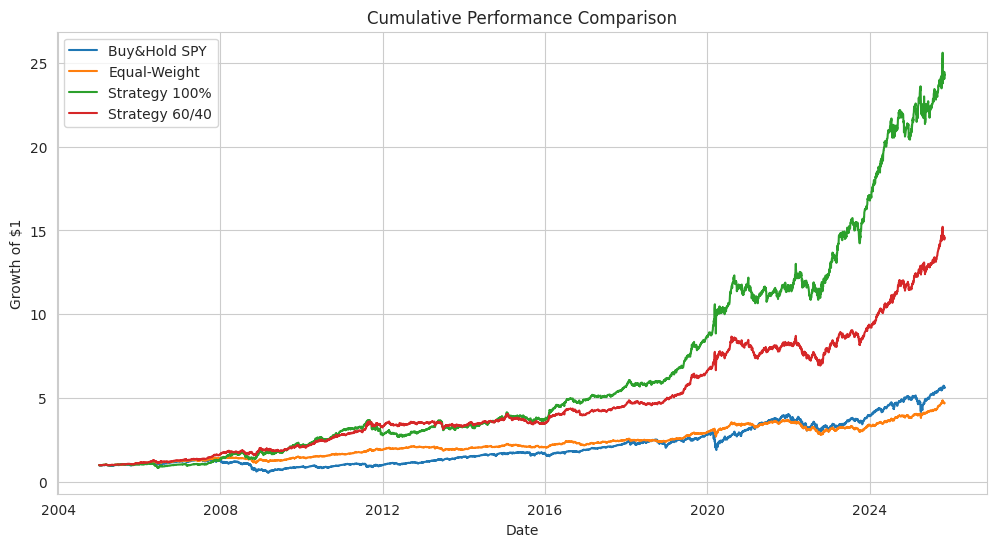

In [ ]:


# 5.2 Compute cumulative returns

strats = {
    "Buy&Hold SPY" : bh_spy,
    "Equal-Weight" : returns["eq_weight"],
    "Strategy 100%" : returns["strat_100p"],
    "Strategy 60/40" : returns["strat_60_40p"],
}

cum_curves = pd.DataFrame(index=returns.index)

for name, r in strats.items():
    cum_curves[name] = (1 + r).cumprod()

# cumulative plot
plt.figure(figsize=(12,6))
for col in cum_curves.columns:
    plt.plot(cum_curves.index, cum_curves[col], label=col)
plt.title("Cumulative Performance Comparison")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()


In [ ]:
# 5.3 Performance table

perf_rows = []

for name, r in strats.items():
    ann_r = annualized_return(r)
    ann_v = annualized_vol(r)
    sharpe = sharpe_ratio(r)
    mdd = max_drawdown((1+r).cumprod())

    perf_rows.append([name, ann_r, ann_v, sharpe, mdd])

perf_df = pd.DataFrame(
    perf_rows,
    columns=["Strategy", "Ann. Return", "Ann. Volatility", "Sharpe", "Max Drawdown"]
)


perf_df["Ann. Return"] = perf_df["Ann. Return"].map(lambda x: f"{x:.2%}")
perf_df["Ann. Volatility"] = perf_df["Ann. Volatility"].map(lambda x: f"{x:.2%}")
perf_df["Sharpe"] = perf_df["Sharpe"].map(lambda x: f"{x:.2f}")
perf_df["Max Drawdown"] = perf_df["Max Drawdown"].map(lambda x: f"{x:.2%}")

print("\nPerformance Comparison Table:")
display(perf_df)


Performance Comparison Table:


,Strategy,Ann. Return,Ann. Volatility,Sharpe,Max Drawdown
0,Buy&Hold SPY,8.63%,19.11%,0.45,-59.58%
1,Equal-Weight,7.71%,9.67%,0.80,-23.99%
2,Strategy 100%,16.59%,14.96%,1.11,-27.49%
3,Strategy 60/40,13.73%,11.85%,1.16,-20.37%
